<a href="https://colab.research.google.com/github/nguyetvo/CBD-Melbourne-Housing-Predict/blob/master/Melbourne_Housing_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import libraries for pre-processing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from dateutil.parser import parse
from datetime import datetime
from scipy.stats import norm

# import all what you need for machine learning
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df =  pd.read_csv('/content/drive/My Drive/Melbourne Housing Predict/Melbourne_housing_FULL.csv')
#df1 = pd.read_csv('/content/drive/My Drive/Melbourne Housing Predict/MELBOURNE_HOUSE_PRICES_LESS.csv')

In [4]:
df.shape

(34857, 21)

# Have a view at dataset

In [5]:
df.sample(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
27246,Pascoe Vale,1/10 Oak St,3,t,810000.0,PI,Nelson,11/11/2017,8.5,3044.0,NaN,NaN,NaN,NaN,NaN,NaN,Moreland City Council,NaN,NaN,Northern Metropolitan,7485.0
31146,Craigieburn,10 Grove Rd,4,h,761000.0,S,Ray,10/02/2018,20.6,3064.0,4.0,2.0,2.0,NaN,216.0,2009.0,Hume City Council,-37.59450,144.90624,Northern Metropolitan,15510.0
27744,Essendon,50 Fitzgerald Rd,5,h,1560000.0,S,Red,18/11/2017,7.5,3040.0,5.0,3.0,6.0,NaN,152.0,1910.0,Moonee Valley City Council,-37.75460,144.92720,Western Metropolitan,9264.0
34372,Hoppers Crossing,2 Talina Cl,3,h,520000.0,S,Barry,24/02/2018,18.4,3029.0,3.0,2.0,2.0,460.0,121.0,1990.0,Wyndham City Council,-37.87263,144.66732,Western Metropolitan,13830.0
28373,Balwyn North,1/63 Winfield Rd,3,t,1038000.0,S,Noel,25/11/2017,9.7,3104.0,NaN,NaN,NaN,NaN,NaN,NaN,Boroondara City Council,NaN,NaN,Southern Metropolitan,7809.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

Looking at the data information above, we can see that non-numerical data is being considered as object. The list included following columns: 
- 'Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea','Regionname'. I will be changing object data type to categorical.
- 'Date' to date type.
- change Bathroom and Car to integer Series
- Postcode is a categorical variable, not a numeric one
- Yearbuilt should be an integer
- Propertycount is a category



In [0]:
#change Postcode
df['Postcode']= df['Postcode'].astype('object')
#change Bathroom and car to integer. Before the transformation I need to convert all the missing values to 0. 
#lastly, change Propertycount to category
df['Propertycount']= df['Propertycount'].astype('object')

In [8]:
## verifying columns with object data type
print(df.select_dtypes(["object"]).columns)

Index(['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'Postcode',
       'CouncilArea', 'Regionname', 'Propertycount'],
      dtype='object')


In [0]:
objdtype_cols = df.select_dtypes(["object"]).columns
df[objdtype_cols] = df[objdtype_cols].astype('category')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         34857 non-null  category
 1   Address        34857 non-null  category
 2   Rooms          34857 non-null  int64   
 3   Type           34857 non-null  category
 4   Price          27247 non-null  float64 
 5   Method         34857 non-null  category
 6   SellerG        34857 non-null  category
 7   Date           34857 non-null  category
 8   Distance       34856 non-null  float64 
 9   Postcode       34856 non-null  category
 10  Bedroom2       26640 non-null  float64 
 11  Bathroom       26631 non-null  float64 
 12  Car            26129 non-null  float64 
 13  Landsize       23047 non-null  float64 
 14  BuildingArea   13742 non-null  float64 
 15  YearBuilt      15551 non-null  float64 
 16  CouncilArea    34854 non-null  category
 17  Lattitude      26881 non-null  

**Duplicate Variables**

According to dataset documentation, 'Rooms' and 'Bedroom2' both contain information on the number of rooms of a home has, but reported from different sources. I will investigate these columns further to determine if one should be removed from the dataset.

In [11]:
df['b 2 r'] = df["Bedroom2"] - df["Rooms"]
df[['b 2 r', 'Bedroom2', 'Rooms']].head()

,b 2 r,Bedroom2,Rooms
0,0.0,2.0,2
1,0.0,2.0,2
2,0.0,2.0,2
3,0.0,3.0,3
4,0.0,3.0,3


In [0]:
## We can see that the difference is very minimal here that is will be wise to remove one of the 2 columns
df = df.drop(['b 2 r', 'Bedroom2'], 1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Suburb         34857 non-null  category
 1   Address        34857 non-null  category
 2   Rooms          34857 non-null  int64   
 3   Type           34857 non-null  category
 4   Price          27247 non-null  float64 
 5   Method         34857 non-null  category
 6   SellerG        34857 non-null  category
 7   Date           34857 non-null  category
 8   Distance       34856 non-null  float64 
 9   Postcode       34856 non-null  category
 10  Bathroom       26631 non-null  float64 
 11  Car            26129 non-null  float64 
 12  Landsize       23047 non-null  float64 
 13  BuildingArea   13742 non-null  float64 
 14  YearBuilt      15551 non-null  float64 
 15  CouncilArea    34854 non-null  category
 16  Lattitude      26881 non-null  float64 
 17  Longtitude     26881 non-null  

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,34857.0,3.031012e+00,0.969933,1.00000,2.00000,3.0000,4.000000e+00,1.600000e+01
Price,27247.0,1.050173e+06,641467.130105,85000.00000,635000.00000,870000.0000,1.295000e+06,1.120000e+07
Distance,34856.0,1.118493e+01,6.788892,0.00000,6.40000,10.3000,1.400000e+01,4.810000e+01
Bathroom,26631.0,1.624798e+00,0.724212,0.00000,1.00000,2.0000,2.000000e+00,1.200000e+01
Car,26129.0,1.728845e+00,1.010771,0.00000,1.00000,2.0000,2.000000e+00,2.600000e+01
Landsize,23047.0,5.935990e+02,3398.841946,0.00000,224.00000,521.0000,6.700000e+02,4.330140e+05
BuildingArea,13742.0,1.602564e+02,401.267060,0.00000,102.00000,136.0000,1.880000e+02,4.451500e+04
YearBuilt,15551.0,1.965290e+03,37.328178,1196.00000,1940.00000,1970.0000,2.000000e+03,2.106000e+03
Lattitude,26881.0,-3.781063e+01,0.090279,-38.19043,-37.86295,-37.8076,-3.775410e+01,-3.739020e+01
Longtitude,26881.0,1.450019e+02,0.120169,144.42379,144.93350,145.0078,1.450719e+02,1.455264e+02


There are some strange values in this table, so let's check this values before moving on:

Check number of bathrooms (<1 and >7)

check building area=0 and building area 44515 square meters

check properties with YearBuilt > 2018

In [15]:
# check number of bathrooms
df['Bathroom'].value_counts()

1.0     12969
2.0     11064
3.0      2181
4.0       269
5.0        77
0.0        46
6.0        16
7.0         4
8.0         3
9.0         1
12.0        1
Name: Bathroom, dtype: int64

It seems that *46 properties* *do not have* the *bathroom!* I think they should be old houses with a common bathroom outside, or something like that, so I will restrain myself from considering them an error. Of course, I do find strange that there is *a property with 12 bathrooms,* though I guess it is technically possible. Let's take a look to houses with more than 7 bathrooms.

In [16]:
df.loc[df.Bathroom>7].head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
2536,Burwood,36 Cumming St,3,h,NaN,PI,Ross,8/10/2016,11.7,3125.0,12.0,0.0,946.0,NaN,1950.0,Monash City Council,-37.85300,145.11290,Southern Metropolitan,5678.0
8251,Preston,421 Murray Rd,4,h,760000.0,PI,Barry,22/05/2016,8.8,3072.0,8.0,7.0,1254.0,280.0,1928.0,Darebin City Council,-37.73670,144.98950,Northern Metropolitan,14577.0
17472,Camberwell,1088 Toorak Rd,8,h,2200000.0,PI,Ross,8/07/2017,7.7,3124.0,8.0,4.0,650.0,NaN,NaN,Boroondara City Council,-37.84812,145.07414,Southern Metropolitan,8920.0
25717,Burwood,79 Elgar Rd,10,h,2315000.0,SP,Buxton,28/10/2017,10.4,3125.0,9.0,2.0,612.0,466.0,2015.0,Monash City Council,-37.84461,145.10968,Southern Metropolitan,5678.0
26210,Mitcham,20 Harrison St,16,h,5000000.0,S,Buxton,28/10/2017,17.2,3132.0,8.0,8.0,NaN,NaN,NaN,Whitehorse City Council,-37.81405,145.19891,Eastern Metropolitan,6871.0


In [17]:
#check building area 
df.loc[df.BuildingArea<1].head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
7211,North Melbourne,19 Shands La,2,t,841000.0,S,Jellis,4/03/2017,2.3,3051.0,1.0,1.0,215.0,0.00,2000.0,Melbourne City Council,-37.79530,144.94370,Northern Metropolitan,6821.0
16540,South Melbourne,148 Cobden St,3,h,NaN,S,Marshall,24/06/2017,1.9,3205.0,2.0,0.0,282.0,0.01,1920.0,Port Phillip City Council,-37.83658,144.96292,Southern Metropolitan,5943.0
19775,Balwyn North,14 Wanbrow Av,5,h,1950000.0,S,RT,3/09/2017,9.7,3104.0,3.0,2.0,743.0,0.00,1949.0,Boroondara City Council,-37.80235,145.09311,Southern Metropolitan,7809.0
19840,Bundoora,22 Moreton Cr,3,h,814000.0,S,Barry,3/09/2017,12.1,3083.0,1.0,2.0,542.0,0.00,1970.0,Banyule City Council,-37.70861,145.05691,Northern Metropolitan,10175.0
20038,Heidelberg Heights,8 Thames St,3,h,NaN,SN,Miles,3/09/2017,8.8,3081.0,1.0,2.0,658.0,0.00,1920.0,Banyule City Council,-37.75287,145.05547,Eastern Metropolitan,2947.0


In [18]:
df['BuildingArea'].loc[df.BuildingArea<1].count()

77

Ok, so it appears that *77 houses do not have any building area.* It may be that some of these values are simply *data entry mistakes*. 

Another possibility is that these properties were sold only because of their land, as building plots and that there was still no house in it. 

However, if this was not the case how come that we know for almost everyone of them YearBuilt, that is the year the house was built? In conclusion, I think there is something wrong with most of this subsample, so I will drop these rows.

In [19]:
#delete the rows
df = df[~(df['BuildingArea'] < 1)]  
#check the deletion
df['BuildingArea'].loc[df.BuildingArea<1].count()

0

In [0]:
#it is important now to reset the index, otherwise I will have some missing rows in my dataframe, which may be troublesome later.
df = df.reset_index()

The boxplot shows an outstanding outlier, with a building area of more than 40000 squared meters. Let's get a closer look to its values.

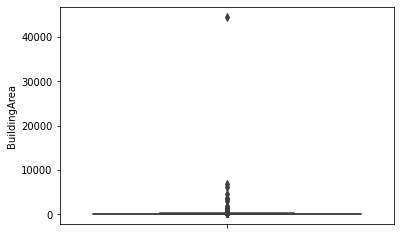

In [21]:
sns.boxplot(data = df, y = 'BuildingArea')

In [22]:
df.loc[df.BuildingArea>40000]

,index,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
22614,22632,New Gisborne,71 Hamilton Rd,5,h,1355000.0,S,Raine,23/09/2017,48.1,3438.0,3.0,5.0,44500.0,44515.0,NaN,Macedon Ranges Shire Council,-37.45392,144.58864,Northern Victoria,849.0


Ok, so this seems a very large property with a lot of land. The building area value is probably an error, as it is bigger than the landsize, and considering that this house has 5 rooms and three bathrooms, it is fair to assume that it cannot be much larger than 500 squared meters. The median value for building area is 136. I will change this value to 445 squared meters, a tenth of its reported size, on account that I think it's possibly bigger than the average house, given the landsize. Of course this line of thought may be biased: I cannot exclude that the property was some kind of factory or company headquarters. I'll stop here for building area.

In [0]:
#replace outlier building area
df['BuildingArea'].replace(44515.0, 445, inplace=True)

In [24]:
df.YearBuilt[df.YearBuilt >= 2020].value_counts(dropna=False)

2106.0    1
Name: YearBuilt, dtype: int64

In [25]:
# check YearBuilt > 2018
print(df['YearBuilt'].loc[df.YearBuilt>2018])

2453     2106.0
32960    2019.0
Name: YearBuilt, dtype: float64


In [0]:
# replace 2106 with 2016 and 2019 with 2018
df['YearBuilt'].replace([2106, 2019], [2016, 2018], inplace=True)

# Working with missing data and outlier

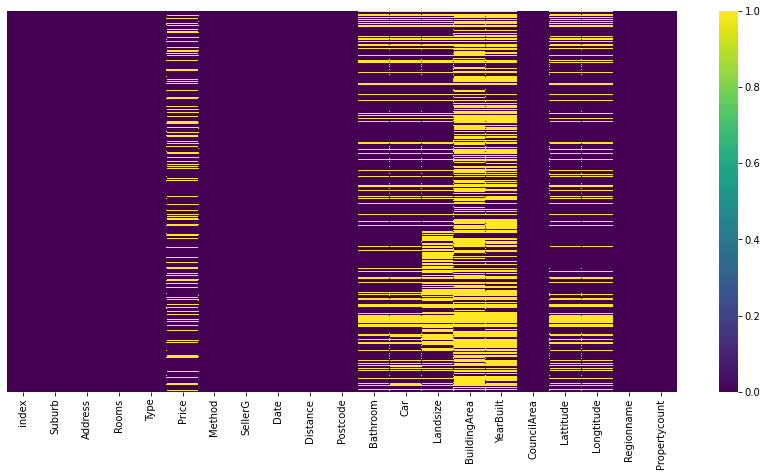

In [27]:
## visualizing missing values
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df.isnull(), yticklabels=False,cmap='viridis')

In [28]:
# check missing data
df.isnull().sum()

index                0
Suburb               0
Address              0
Rooms                0
Type                 0
Price             7594
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bathroom          8226
Car               8726
Landsize         11790
BuildingArea     21115
YearBuilt        19304
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

Many of the variables suffer from missing values. Building area is the most affected by them. I would like to explore it's relationship with price and at the same time evaluate whether it is better to impute the missing values with their mean or median.

In [0]:
# We will save the "cured" data columns in variables
#first with the mean
priceWithMean = df['Price'].fillna(df['Price'].mean())
BAWithMean = df['BuildingArea'].fillna(df['BuildingArea'].mean())

#now with the median
priceMedian = df['Price'].fillna(df['Price'].median())
BAMedian = df['BuildingArea'].fillna(df['BuildingArea'].median())

In [0]:
missVIDsJoint = df['Price'].isnull() | df['BuildingArea'].isnull()
# missVIDsJoint now has a True for items that are missing an Age or a Fare value

In [0]:
 #create a dictionary to indicate different colors, missing values will be orange
colorChoiceDict = {True: (1.0, 0.55, 0.0, 1.0), False: (0.11, 0.65, 0.72, 0.1)}

# create a column with color values using list comprehension
colorCol = [colorChoiceDict[val] for val in missVIDsJoint]

Text(0, 0.5, 'Price')

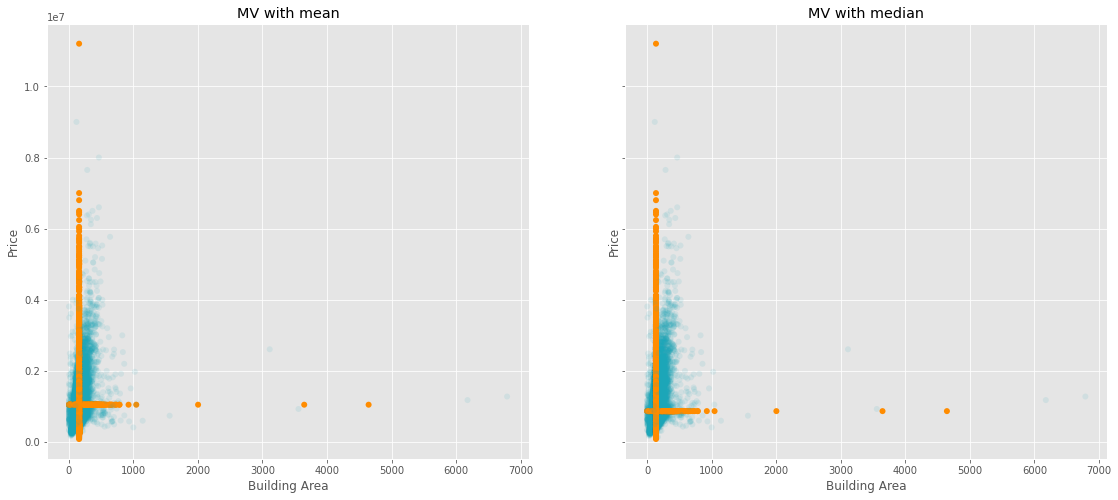

In [32]:
plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(19, 8))
ax1.scatter(BAWithMean, priceWithMean, c = colorCol, linewidth=0)
ax1.set_title('MV with mean')
ax1.set_xlabel('Building Area')
ax1.set_ylabel('Price')
ax2.scatter(BAMedian, priceMedian, c = colorCol, linewidth=0)
ax2.set_title('MV with median')
ax2.set_xlabel('Building Area')
ax2.set_ylabel('Price')

In both graphs we can see where the imputed values would be. There is not a striking visual difference between the two graphs. However, after a careful look we can say that Price has a lot of outliers, and the median is less affected by them, as the horizontal line in the graph on the right is lower. In any case, considering the heavy presence of outliers, I think that in both cases it would be better to use the median, as the mean values are more sensitive to outliers. Another possible option - to guard against outliers - would be to use robust statistics. In the next cell I am going to impute all numerical variables with the median.

In [33]:
df['Price']= df['Price'].fillna(df['Price'].median())
df['Landsize']= df['Landsize'].fillna(df['Landsize'].median())
#Similarly, fill the only missing value of  all the other numeric values
df['Distance'] = df['Distance'].fillna(df['Distance'].median())
df['BuildingArea']= df['BuildingArea'].fillna(df['BuildingArea'].median())
df['Lattitude']= df['Lattitude'].fillna(df['Lattitude'].median())
df['Longtitude']= df['Longtitude'].fillna(df['Longtitude'].median())
df['YearBuilt']= df['YearBuilt'].fillna(df['YearBuilt'].median())
df.isnull().sum()

index               0
Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            1
Bathroom         8226
Car              8726
Landsize            0
BuildingArea        0
YearBuilt           0
CouncilArea         3
Lattitude           0
Longtitude          0
Regionname          3
Propertycount       3
dtype: int64

Now the categorical variables. In this case I think the simplest way to deal with missing values is to sobstitute them with the mode

In [34]:
df['Bathroom']= df['Bathroom'].fillna(df['Bathroom'].mode()[0])
df['Car']= df['Car'].fillna(df['Car'].mode()[0])
df['CouncilArea']= df['CouncilArea'].fillna(df['CouncilArea'].mode()[0])
df['Regionname']= df['Regionname'].fillna(df['Regionname'].mode()[0])
df['Propertycount']= df['Propertycount'].fillna(df['Propertycount'].mode()[0])
df['Postcode']= df['Postcode'].fillna(df['Postcode'].mode()[0])
df.isnull().sum()

index            0
Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64

After deling with missing values, I can change the type of Bathroom and Car to integer

In [0]:
df['Bathroom'] = pd.to_numeric(df['Bathroom']).round(0).astype(int)
df['Car'] = pd.to_numeric(df['Car']).round(0).astype(int)

**Outliers**

Outliers can significantly impact data analysis and can also impact normalization of data. It is very important in during data prepration to indentify them remove them. In next few steps we will work in our data to get rid of outliers (if any)

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,34780.0,1.741107e+04,10065.076488,0.00000,8695.750000,17391.5000,2.613725e+04,3.485600e+04
Rooms,34780.0,3.030305e+00,0.969948,1.00000,2.000000,3.0000,4.000000e+00,1.600000e+01
Price,34780.0,1.010800e+06,571944.445856,85000.00000,695000.000000,870000.0000,1.150000e+06,1.120000e+07
Distance,34780.0,1.118073e+01,6.785377,0.00000,6.400000,10.3000,1.400000e+01,4.810000e+01
Bathroom,34780.0,1.476912e+00,0.686453,0.00000,1.000000,1.0000,2.000000e+00,1.200000e+01
Car,34780.0,1.796780e+00,0.882623,0.00000,1.000000,2.0000,2.000000e+00,2.600000e+01
Landsize,34780.0,5.688052e+02,2766.828017,0.00000,357.000000,520.5000,5.980000e+02,4.330140e+05
BuildingArea,34780.0,1.446180e+02,84.305450,1.00000,136.000000,136.0000,1.360000e+02,6.791000e+03
YearBuilt,34780.0,1.967886e+03,25.012460,1196.00000,1970.000000,1970.0000,1.970000e+03,2.018000e+03
Lattitude,34780.0,-3.780999e+01,0.079174,-38.19043,-37.846882,-37.8077,-3.777092e+01,-3.739020e+01


From the statstical summary above we can see that max price in our data is nearly $11.2 million. That looks like a clear outlier. But before removing it, lets first ensure that we have very few values in that range.


In [0]:
#to findout outliers lets divide data into different price ranges to identify number of occurences of data in different price ranges
df['PriceRange'] = np.where(df['Price'] <= 100000, '0-100,000',  
                   np.where((df['Price'] > 100000) & (df['Price'] <= 1000000), '100,001 - 1M',
                   np.where((df['Price'] > 1000000) & (df['Price'] <= 3000000), '1M - 3M',
                   np.where((df['Price']>3000000) & (df['Price']<=5000000), '3M - 5M',
                   np.where((df['Price']>5000000) & (df['Price']<=6000000), '5M - 6M',
                   np.where((df['Price']>6000000) & (df['Price']<=7000000), '6M - 7M',
                   np.where((df['Price']>7000000) & (df['Price']<=8000000), '7M-8M', 
                   np.where((df['Price']>8000000) & (df['Price']<=9000000), '8M-9M', 
                   np.where((df['Price']>9000000) & (df['Price']<=10000000), '9M-10M', 
                   np.where((df['Price']>10000000) & (df['Price']<=11000000), '10M-11M', 
                   np.where((df['Price']>11000000) & (df['Price']<=12000000), '11M-12M', '')))))))))))

In [38]:
df.groupby(['PriceRange']).agg({'PriceRange': ['count']})

,PriceRange
,count
PriceRange,
"0-100,000",1
"100,001 - 1M",24051
11M-12M,1
1M - 3M,10283
3M - 5M,387
5M - 6M,40
6M - 7M,14
7M-8M,2


By exploring above table, it can be concluded that:

1 data item in the range 0-100,00

2 data item in range 7M - 8M

1 data item in range 8M - 9M

1 data item in range 11M - 12M 

For the purpose of this study, let us drop rows that match above mentioned conditions

In [0]:
# create additional columns filled with 0 values
df["isOutlierPrice"] = 0 
df["isOutlierDistance"] = 0

# save the mean and standard deviation in variables
meanPrice = df['Price'].mean()
stdDevPrice = df['Price'].std()

meanDistance = df['Distance'].mean()
stdDevDistance = df['Distance'].std()

#mark outliers as 
df['isOutlierPrice'] = np.where(abs(df['Price'] - meanPrice) > 5 * stdDevPrice, 1, 0)
df['isOutlierDistance'] = np.where(abs(df['Distance'] - meanDistance) > 5 * stdDevDistance, 1, 0)

In [0]:
#create a function to compute the percentage of missing values
def percent(nom, denom):
    res= (nom*100)/denom
    print("%.3f%%" % round(res,3))

#percentage of MV for Price
percent(df["isOutlierPrice"].value_counts()[1], df["isOutlierPrice"].value_counts()[0])   

0.465%


In [0]:
#percentage of MV for Landsize
percent(df["isOutlierDistance"].value_counts()[1], df["isOutlierDistance"].value_counts()[0])   

0.196%


With this high threshold, less than 1% of values are considered outliers. The next graph visualize this proportion.

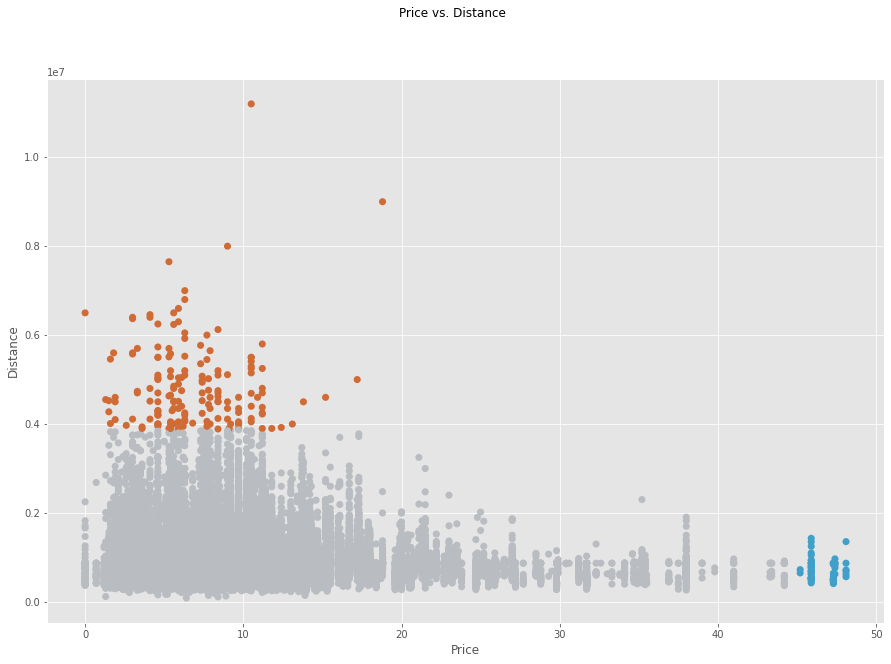

In [0]:
# This part helps us to generate a color array with different colors for the 1D outliers we compute

# first create an empty list
colorColumn = []
# we make use of the HEX color codes to use nicely distinguisable colors
for i in range(len(df)):
    if df["isOutlierPrice"][i]== 1:
        colorColumn.append("#D06B36") # orange color
    elif df["isOutlierDistance"][i] == 1:
        colorColumn.append("#40A0C9") # a blueish color
    else:
        colorColumn.append("#B9BCC0") # gray

plt.figure(figsize=(15,10))
plt.xlabel('Price')
plt.suptitle('Price vs. Distance')
plt.ylabel('Distance')
plt.scatter(df.Distance, df.Price , c = colorColumn, s = 50, linewidth=0)

A 'Price' outlier clearly stands out: it is well beyond 7 standard deviation from the mean of the distribution (it's exact value is 11.200.000 dollars). Let's take a closer look to this property.

In [0]:
#take just the price outlier
df.iloc[:,:19][df.Price > 11000000]

,index,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude
25585,25635,Brighton,6 Cole St,4,h,11200000.0,VB,hockingstuart,28/10/2017,10.5,3186.0,3,2,1400.0,136.0,1970.0,Bayside City Council,-37.89335,144.98643


So we now know that this house it's located at Brighton, which according to Wikipedia 'houses some of the wealthiest citizens in Melbourne'. The house is probably a cottage (Type h) on the sea.

In [0]:
# check number of bedrooms
df.groupby(['Rooms'])['Rooms'].count()

Rooms
1      1479
2      8319
3     15051
4      7933
5      1730
6       203
7        32
8        19
9         4
10        6
12        3
16        1
Name: Rooms, dtype: int64

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34780 entries, 0 to 34779
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   index              34780 non-null  int64   
 1   Suburb             34780 non-null  category
 2   Address            34780 non-null  category
 3   Rooms              34780 non-null  int64   
 4   Type               34780 non-null  category
 5   Price              34780 non-null  float64 
 6   Method             34780 non-null  category
 7   SellerG            34780 non-null  category
 8   Date               34780 non-null  category
 9   Distance           34780 non-null  float64 
 10  Postcode           34780 non-null  category
 11  Bathroom           34780 non-null  int64   
 12  Car                34780 non-null  int64   
 13  Landsize           34780 non-null  float64 
 14  BuildingArea       34780 non-null  float64 
 15  YearBuilt          34780 non-null  float64 
 16  Coun

**Feature engineering**

In [0]:
#create variable number of years since building
df['houseAge'] = 2018-df['YearBuilt']

In [0]:
#Then create two new categories from the variable Date: year and season.
#create the new column data restructuring the original Date column with pd.to_datetime
df['data'] = pd.to_datetime(df['Date'])

In [0]:
# calculate day of year
df['doy'] = df['data'].dt.dayofyear
# Create year
df['Year'] = df['data'].dt.year

#to divide by season it's better to use the day of the year instead of the months
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
# winter = everything else

daje = []
for i in df['doy']:
    if i in spring:
        season = 'spring'
    elif i in summer:
        season = 'summer'
    elif i in fall:
        season = 'fall'
    else:
        season = 'winter'
    daje.append(season)   

#add the resulting column to the dataframe (after transforming it as a Series)
df['season']= pd.Series(daje)


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34780 entries, 0 to 34779
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   index              34780 non-null  int64   
 1   Suburb             34780 non-null  category
 2   Address            34780 non-null  category
 3   Rooms              34780 non-null  int64   
 4   Type               34780 non-null  category
 5   Price              34780 non-null  float64 
 6   Method             34780 non-null  category
 7   SellerG            34780 non-null  category
 8   Date               34780 non-null  category
 9   Distance           34780 non-null  float64 
 10  Postcode           34780 non-null  category
 11  Bathroom           34780 non-null  int64   
 12  Car                34780 non-null  int64   
 13  Landsize           34780 non-null  float64 
 14  BuildingArea       34780 non-null  float64 
 15  YearBuilt          34780 non-null  float64 
 16  Coun

# EDA

**Data presentation and relationship**

In [0]:
#data subset by type
#house price
melbourne_data_h=df[df['Type']=='h']
#condo price
melbourne_data_u=df[df['Type']=='u']
#townhouse price
melbourne_data_t=df[df['Type']=='t']
#house,condo and town house price groupby year and mean
melbourne_data_h_y=melbourne_data_h.groupby('Year').mean()
melbourne_data_u_y=melbourne_data_u.groupby('Year').mean()
melbourne_data_t_y=melbourne_data_t.groupby('Year').mean()
melbourne_data_h_y.head()

,index,Rooms,Price,Distance,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,isOutlierPrice,isOutlierDistance,houseAge,doy
Year,,,,,,,,,,,,,,,
2016,5938.960769,3.272342,1.189059e+06,9.069237,1.525295,1.750985,519.136474,153.456377,1957.673735,-37.806828,144.993851,0.008179,0.000000,60.326265,212.993184
2017,20068.622571,3.382089,1.112173e+06,13.154621,1.596114,1.926364,647.095755,152.311515,1966.351545,-37.807953,145.007481,0.006095,0.003585,51.648455,212.586793
2018,32359.880606,3.417879,1.068573e+06,14.162697,1.688744,2.006831,651.083457,154.215325,1967.889516,-37.799792,145.003120,0.005940,0.004752,50.110484,98.271458


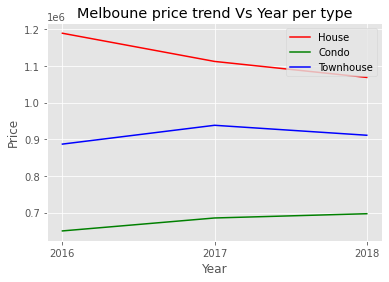

In [0]:
#sns.lmplot(x="Year", y="Price", hue="Type", data=melbourne_data,  x_estimator=np.mean);
melbourne_data_h_y['Price'].plot(kind='line', color='r',label='House')
melbourne_data_u_y['Price'].plot(kind='line', color='g',label='Condo')
melbourne_data_t_y['Price'].plot(kind='line', color='b',label='Townhouse')
year_xticks=[2016,2017,2018]
plt.ylabel('Price')
plt.xticks( year_xticks)
plt.title('Melboune price trend Vs Year per type')
plt.legend()

House price was going down dramatically by 100,000 units Condo price climb up slowly while Townhouse price kept steady. From this graph, it is anticipated that house price will keptgoing down but less slope Townhouse price will kepte unchanged Condo price will increase. To developer, it is time to built more condos in 2019.House budget need to be cut For home buyers, it is time to buy house in 2019.

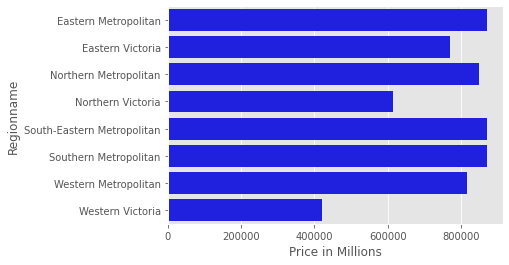

In [0]:
selected_data = df.groupby('Regionname').median().reset_index().sort_values('Price',ascending=False)
g=sns.barplot(y='Regionname',x='Price',data=selected_data,orient='h',color='b')
g.set_xlabel("Price in Millions")
plt.show()

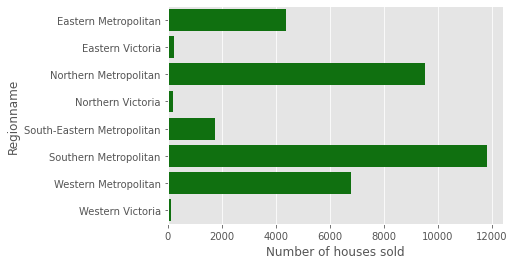

In [0]:
selected_data = df.groupby('Regionname').count().reset_index().sort_values('Price',ascending=False)
g=sns.barplot(y='Regionname',x='Price',data=selected_data,orient='h',color='g')
g.set_xlabel("Number of houses sold")
plt.show()

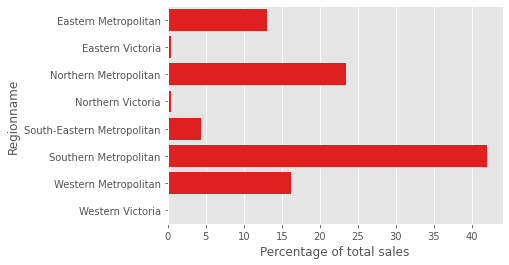

In [0]:
df2 = df.groupby('Regionname').sum().reset_index()[['Regionname','Price']]
df2['Percentage_Price'] = 100*df2['Price']/df2['Price'].sum()
df2=df2.sort_values('Percentage_Price',ascending=False)
g=sns.barplot(y='Regionname',x='Percentage_Price',orient='h',data=df2,color='r')
# for index, row in df.iterrows():
#         g.text(row['Percentage_Price'], row.name, np.round(row['Percentage_Price'],2), color='black',ha='left',fontsize = font_size)
#g.set_title('Percentage of total sales vs Regions')
g.set_xlabel('Percentage of total sales')
plt.show()
# df1_fig = bar_plot('Percent of Total Sales','Regionname', df1, fig_size=(14,8),fontscale=1.25,font_size=13, palette="rocket")

**Visualization**

First let's check with boxplots the distribution of ordinal and categorical values

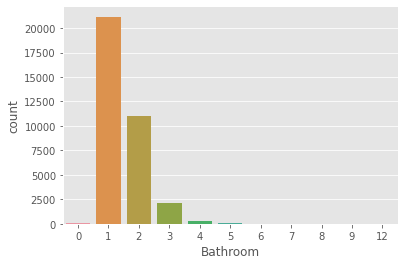

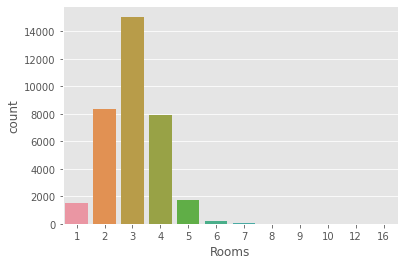

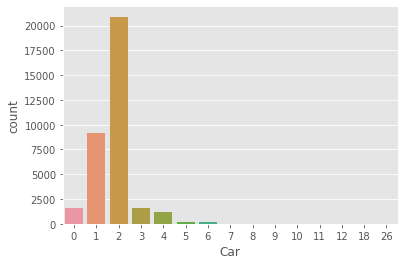

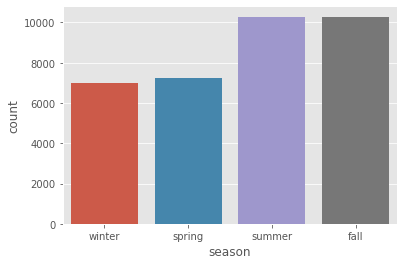

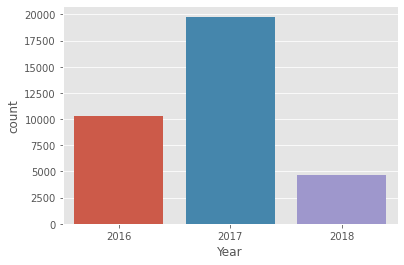

In [0]:
l= ['Bathroom', 'Rooms', 'Car', 'season', 'Year']
for i in l:
    plt.figure()
    sns.countplot(x=i, data=df)

Insights:
- most properties were sold on 2017;
- More properties are sold during summer and fall;
- most houses have space for 2 cars;
- between 2 to four rooms and 1 or 2 bathrooms;

Now I'll take a look at the distribution of continous variables using histograms

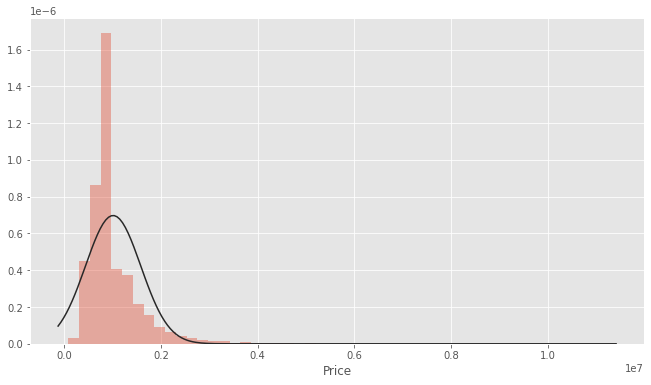

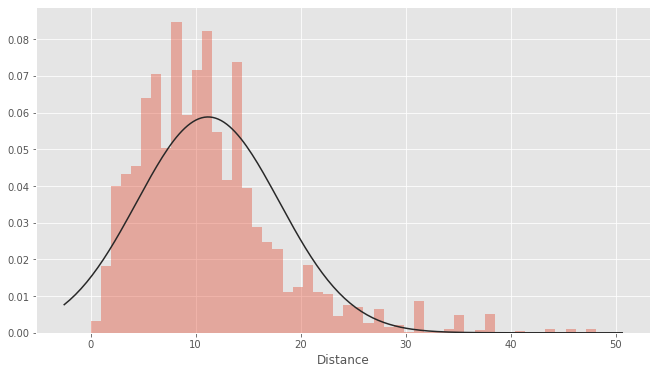

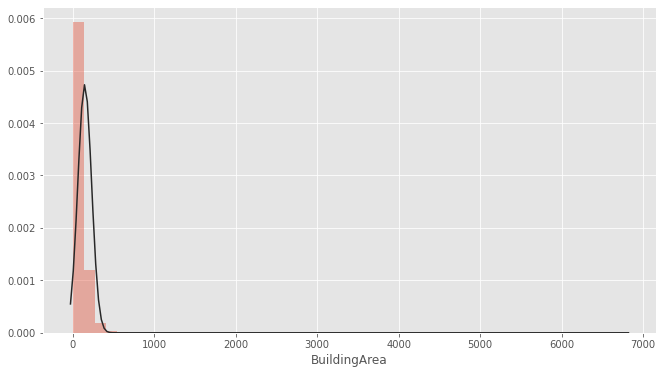

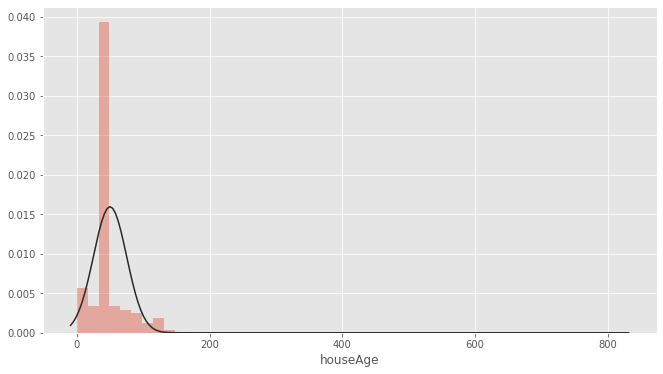

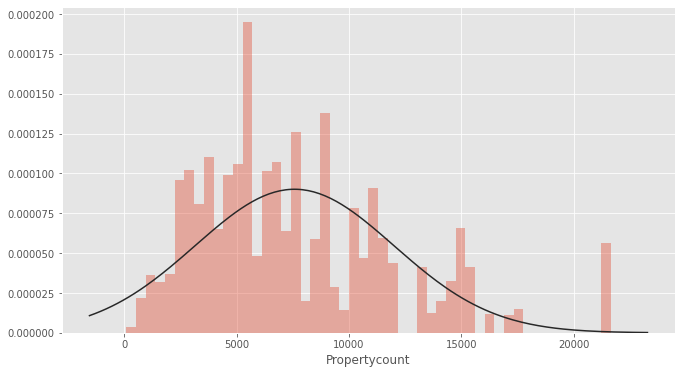

In [0]:
l= [df['Price'], df['Distance'], df['BuildingArea'], df['houseAge'], df['Propertycount']]
for i in l:
    plt.figure(figsize=(11,6))
    sns.distplot(i, fit=norm, kde=False)

(0.0, 1000.0)

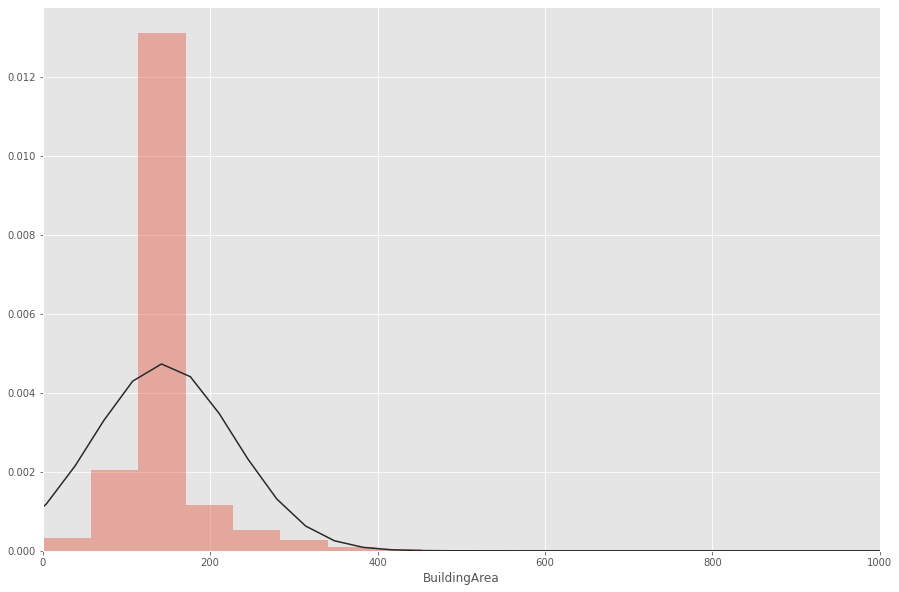

In [0]:
#Let's zoom in for Building Area, which is not very clear by the last graph
plt.figure(figsize=(15,10))
sns.distplot(df['BuildingArea'], fit=norm, bins=120, kde=False)
plt.xlim(0,1000)

Biggest insight here is that all variables have a different scale, there are many outliers for most of them and no one seem really close to normality. These observations will come useful later when I will scale my features.

Now let I check some variables that may influence our dependent variable price.

Text(0.5, 1.0, 'Rooms & Price')

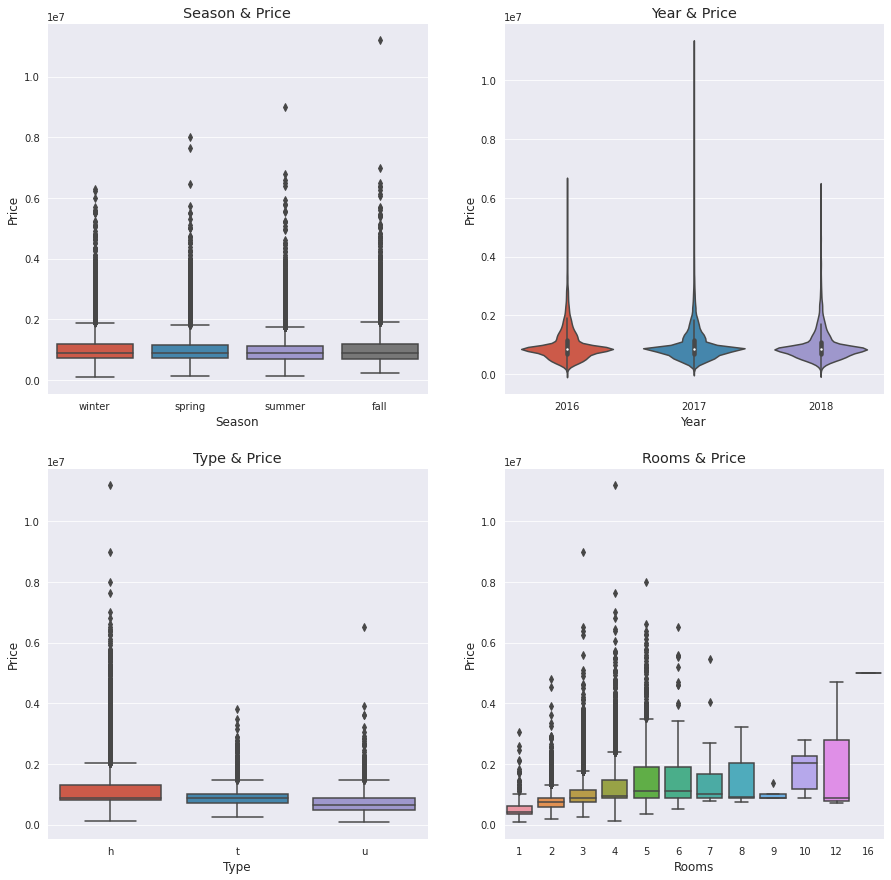

In [0]:
# Suplots of categorical features v price
sns.set_style('darkgrid')
f, axes = plt.subplots(2,2, figsize = (15,15))

# Plot [0,0]
sns.boxplot(data = df, x = 'season', y = 'Price', ax = axes[0, 0])
axes[0,0].set_xlabel('Season')
axes[0,0].set_ylabel('Price')
axes[0,0].set_title('Season & Price')

# Plot [0,1]
sns.violinplot(data = df, x = 'Year', y = 'Price', ax = axes[0, 1])
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Price')
axes[0,1].set_title('Year & Price')

# Plot [1,0]
sns.boxplot(x = 'Type', y = 'Price', data = df, ax = axes[1,0])
axes[1,0].set_xlabel('Type')
axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Type & Price')

# Plot [1,1]
sns.boxplot(x = 'Rooms', y = 'Price', data = df, ax = axes[1,1])
axes[1,1].set_xlabel('Rooms')
axes[1,1].set_ylabel('Price')
axes[1,1].set_title('Rooms & Price')

- Regarding season, there is no big diffence in price between houses sold on different parts of the year;
- As for years, 2017 was the best year for the market, with apparently more high price outliers. 2018 has less activity, perhaps because data collection did not include the whole year.
- It seems that there is a slight linear increase in Price for more rooms. Note that not all the levels of variable rooms are very stable, with 9 and 16 showing very little variability (they surely have few cases).
- Type of house may be an important indicator for price, as is seems that h (cottages) cost more, and have more variability in price.

**Time series**

My first idea was obviously to organize the longitudinal plot wth days on the x-axis and price as y. Considering the size of the dataset I expected to have house sales for almost every day. Unexpectedly, out of all the 2 and a half years, houses were sold only during 78 days (see below the shape computation). I thus decided to order the x-axis by month (but even by week would have been possible). Y-axis represents the total amount of money spent in the housing market during the period of interest.

In [0]:
#use shape to count the number of rows of the database grouped by day using a pivot table.
df.pivot_table('Price', index='data', aggfunc='sum').shape

(78, 1)

([<matplotlib.axis.XTick at 0x7f6dcd7499b0>,
 [Text(0, 0, ''),
  Text(0, 0, 'January'),
  Text(0, 0, 'February'),
  Text(0, 0, 'March'),
  Text(0, 0, 'April'),
  Text(0, 0, 'May'),
  Text(0, 0, 'June'),
  Text(0, 0, 'July'),
  Text(0, 0, 'August'),
  Text(0, 0, 'September'),
  Text(0, 0, 'October'),
  Text(0, 0, 'November'),
  Text(0, 0, 'December')])

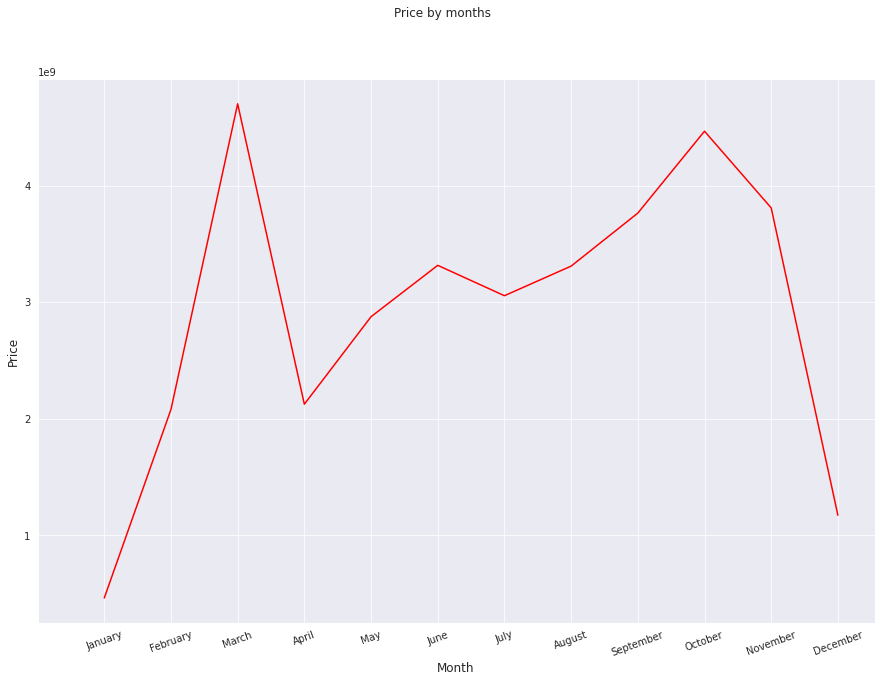

In [0]:
import calendar
# create new column storing the month of each operation
df['month'] = df['data'].dt.month
#use group by (alternative to pivot_table) to have the total value of houses sold per month
by_month= df.groupby('month')['Price'].sum()
#plot figure
plt.figure(figsize=(15,10))
plt.plot(by_month, color="red")
plt.xlabel('Month')
plt.suptitle('Price by months')
plt.ylabel('Price')
plt.xticks(np.arange(13), calendar.month_name[0:13], rotation=20)

In the graph above I simply consider Price by month, similarly to what I did before with boxplots. However, we want to take into account also the year variable. The graph below shows the value of sales by month from 2016 to 2018. Note that in this case also, not all months have been profitable. In fact, only 28 months have been registered in the database, with many months in 2018 missing, as you can see from the x-axis of the graph.

[Text(0, 0, '2016-01'),
 Text(0, 0, '2016-03'),
 Text(0, 0, '2016-04'),
 Text(0, 0, '2016-05'),
 Text(0, 0, '2016-06'),
 Text(0, 0, '2016-07'),
 Text(0, 0, '2016-08'),
 Text(0, 0, '2016-09'),
 Text(0, 0, '2016-10'),
 Text(0, 0, '2016-11'),
 Text(0, 0, '2016-12'),
 Text(0, 0, '2017-01'),
 Text(0, 0, '2017-02'),
 Text(0, 0, '2017-03'),
 Text(0, 0, '2017-04'),
 Text(0, 0, '2017-05'),
 Text(0, 0, '2017-06'),
 Text(0, 0, '2017-07'),
 Text(0, 0, '2017-08'),
 Text(0, 0, '2017-09'),
 Text(0, 0, '2017-10'),
 Text(0, 0, '2017-11'),
 Text(0, 0, '2017-12'),
 Text(0, 0, '2018-01'),
 Text(0, 0, '2018-02'),
 Text(0, 0, '2018-03'),
 Text(0, 0, '2018-06'),
 Text(0, 0, '2018-10')]

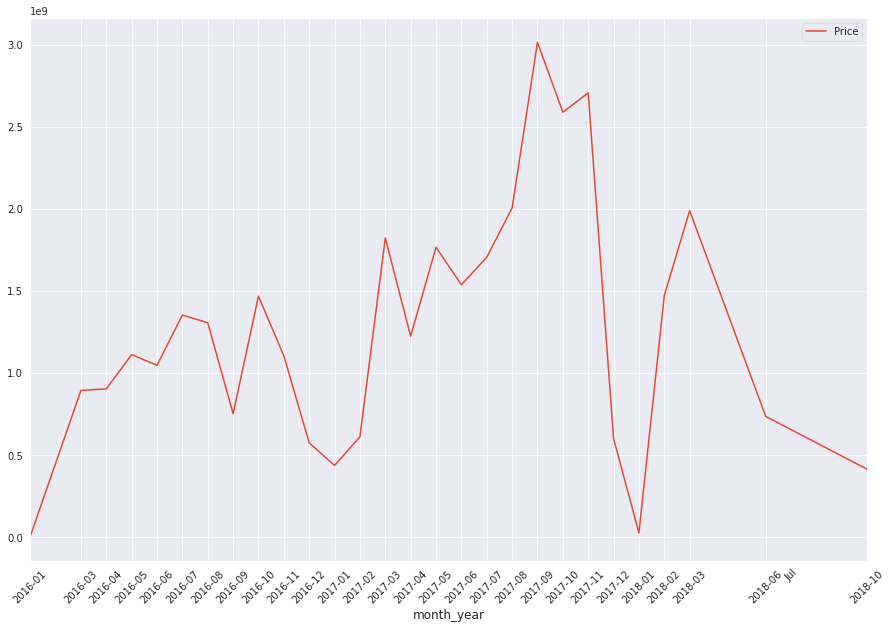

In [0]:
#create index month-year
df['month_year'] = df['data'].dt.to_period('M')
#use groupby to compute the price for each available month, then store the result in a dataframe
by_year_month= pd.Series.to_frame(df.groupby('month_year')['Price'].sum())
#draw graph
fig, ax = plt.subplots(figsize=(15,10))
by_year_month.plot(ax=ax, xticks=by_year_month.index, rot=45)
ax.set_xticklabels(by_year_month.index)

**Correlation matrix and scatterplots**

It is high time to have a look at the correlations between our variables. First I will draw a correlation matrix, and then I will visualize the most promising relationship with scatterplots.

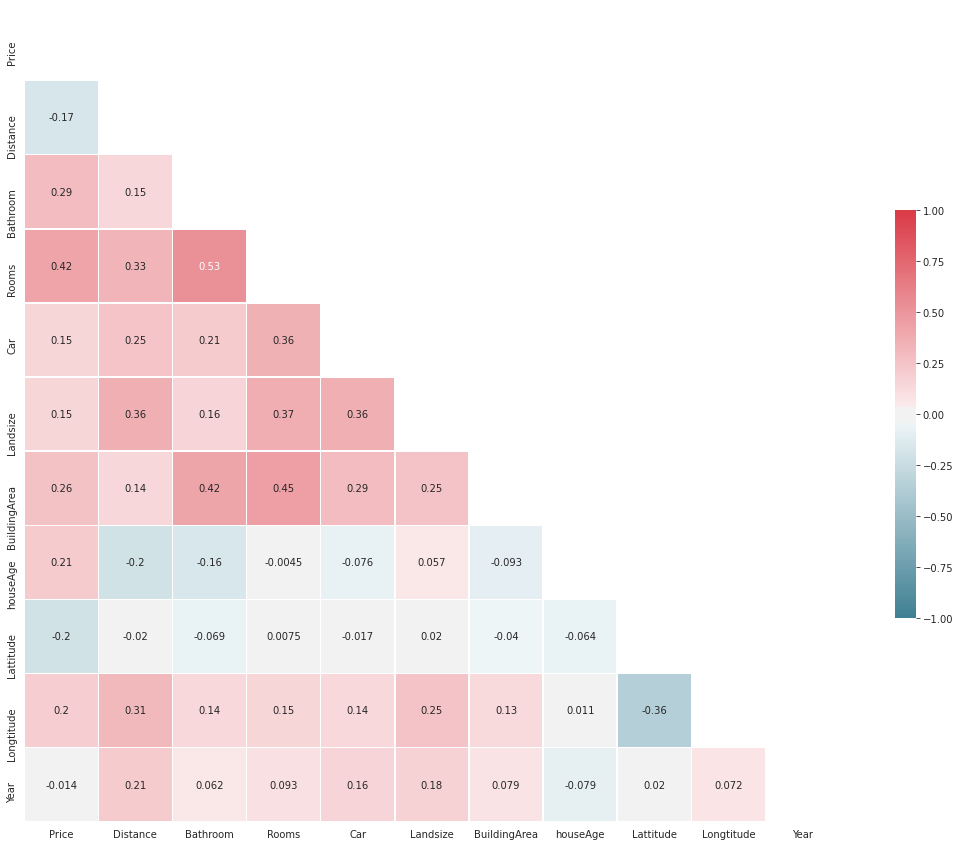

In [0]:
#select only the data we are interested in
attributes= ['Price', 'Distance', 'Bathroom', 'Rooms', 'Car', 'Landsize', 'BuildingArea', 'houseAge', 'Lattitude', 'Longtitude', 
             'Year', 'Propertycount']
h= df[attributes]

#whitegrid
sns.set_style('whitegrid')
#compute correlation matrix...
corr_matrix=h.corr(method='spearman')
#...and show it with a heatmap
#first define the dimension
plt.figure(figsize=(20,15))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

I will now examine the relationship between Price and four other variables:

- BuildingArea (r= .26)
- HouseAge (.21)
- Rooms - This is the strongest relationship (.43).
- Distance - most negative correlation (-.17)

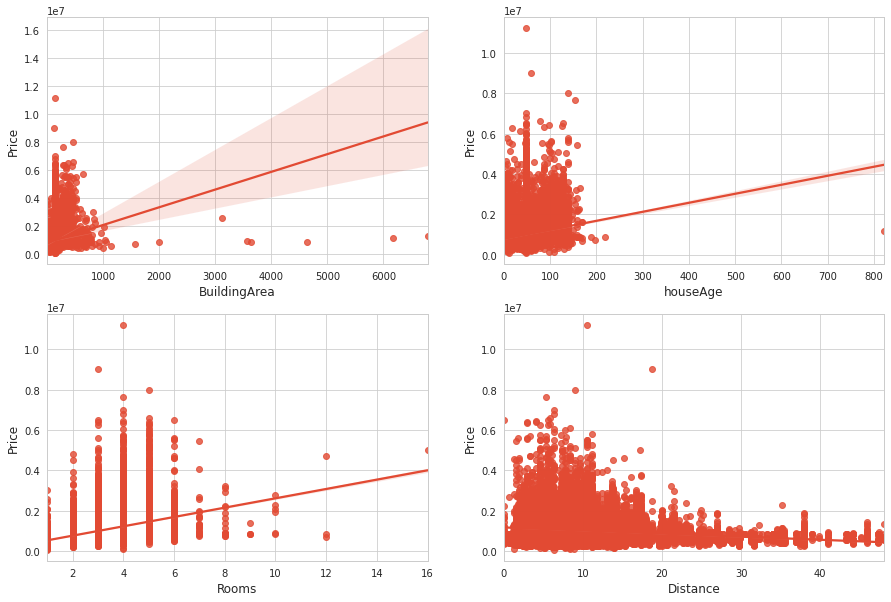

In [0]:
# Scatterplot
f, axes = plt.subplots(figsize = (15,10))
plt.subplot(221)
sns.regplot(data= df, x='BuildingArea', y='Price')
plt.subplot(222)
sns.regplot(data= df, x='houseAge', y='Price')
plt.subplot(223)
sns.regplot(data= df, x='Rooms', y='Price')
plt.subplot(224)
sns.regplot(data= df, x='Distance', y='Price')

Seaborn provides other interesting options to visualize a bivariate relationship, like the jointplot below. This time I used a trick to stop some useless warning that I was not able to fix in any other way.

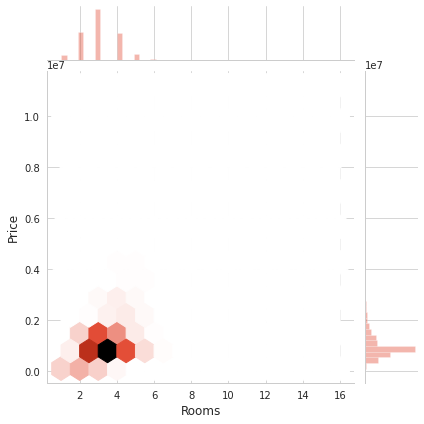

In [0]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Price and distance
    sns.jointplot(y='Price', x='Rooms', data=df, kind='hex', gridsize=15)

Is the type of house influencing the relationship of the variables we examined? For example, when a townhouse gets old I think that it loses value, as we tend to prize more modern venues in western cities. But what about an historical villa deep into the countryside? In that case I think that the price may well increase as the property ages, like a vintage item.

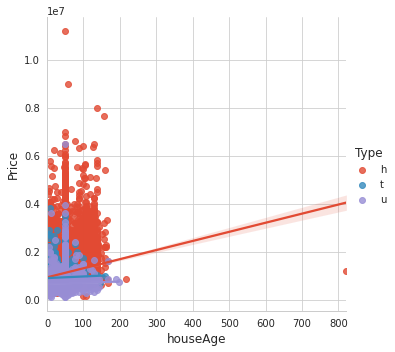

In [0]:
sns.lmplot(data= df, x='houseAge', y= 'Price', hue= 'Type')

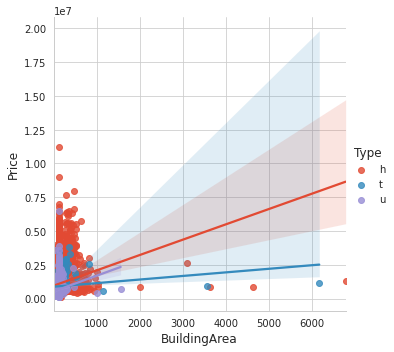

In [0]:
sns.lmplot(data= df, x='BuildingArea', y= 'Price', hue='Type')

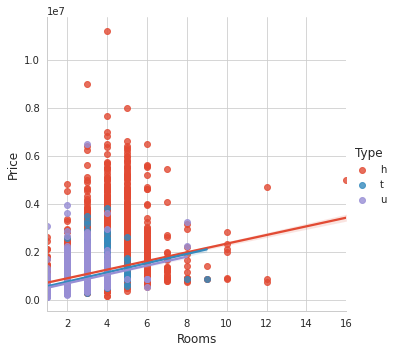

In [0]:
sns.lmplot(data= df, x='Rooms', y= 'Price', hue='Type')

Indeed, it seems that there is an interaction between type of house and its age to determine the price: as the house gets older, the price increases on average, but this is particularly true for Type h, that is cottages and villas. A similar interaction is shown in the second graph, where we see that the price steeply increases for larger properties (bigger BuildingArea), but not for the townhouse Type. On the contrary, Type does not seem to influence the relationship between price and rooms: the more rooms, the better. This baffles me, as I would have expected the same result as in BuildingArea.

**Geographical Data**

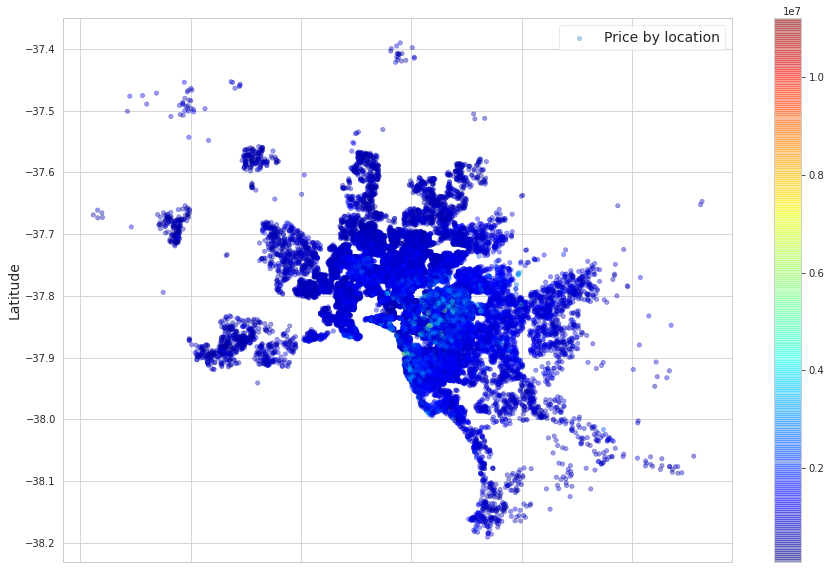

In [0]:
df.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4,
c=df.Price, cmap=plt.get_cmap("jet"), label= 'Price by location', figsize=(15,10)) 
plt.ylabel("Latitude", fontsize=14)

plt.legend(fontsize=14)

This plot is quite confusing, because most values are in the low end of the Price range and they turn out as blue. Perhaps it would be better to first delete the most extreme outliers (let's say 5 std from the mean) and then plot the figure? I also tried normalising the price variable (with log transformation and standard scaler) but this resulted in a completely green map, that is a map dominated by middle values.

In [0]:
df['Price_cut']= df['Price'].loc[df.Price<3500000]

Text(0.5, 1.0, 'AFTER CUT')

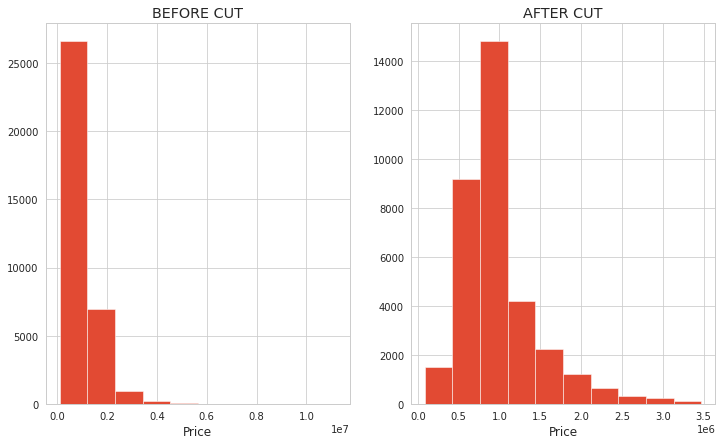

In [0]:
f, axes = plt.subplots(1,2, figsize = (12,7))
# Plot [0,0] full price
df['Price'].hist(ax = axes[0])
axes[0].set_title('BEFORE CUT')
axes[0].set_xlabel('Price')
# Plot [0,1] price cut
df['Price_cut'].hist(ax = axes[1])
axes[1].set_xlabel('Price')
axes[1].set_title('AFTER CUT')

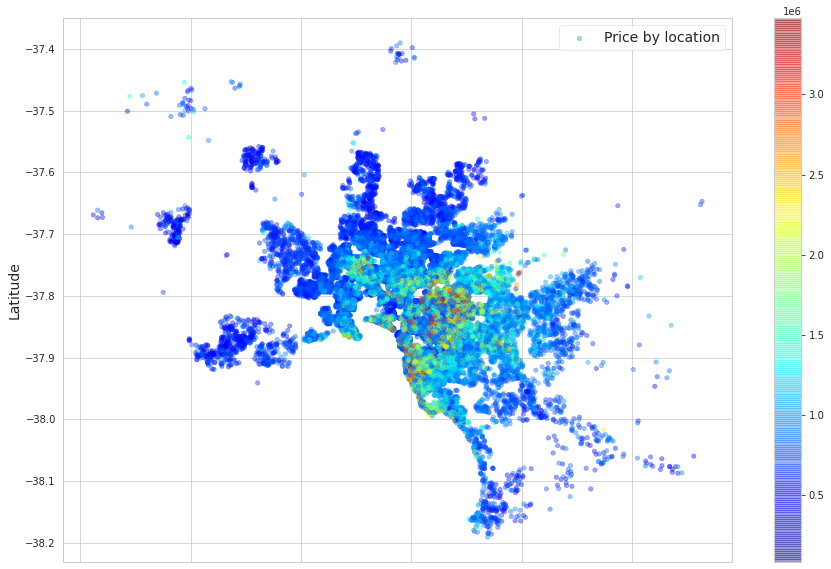

In [0]:
df.plot(kind="scatter", x="Longtitude", y="Lattitude", alpha=0.4,
c=df.Price_cut, cmap=plt.get_cmap("jet"), label= 'Price by location', figsize=(15,10)) 
plt.ylabel("Latitude", fontsize=14)

plt.legend(fontsize=14)

This map let us see that most expensive properties are in a central area not too far from what I think is the sea. Next step would be to superimpose on this scatterplot a real map of the city.

In [0]:
import folium

map_distance_vs_price = folium.Map(location=[-37.81, 144.96],
                        zoom_start = 12)
#Uni Point
folium.Marker([-37.7963, 144.9614],
              popup='Melbourne University',
              icon=folium.Icon(color='red',icon='cloud')
              ).add_to(map_distance_vs_price)

folium.Marker([-37.80782, 144.96294],
              popup='Melbourne RMIT',
              icon=folium.Icon(color='red',icon='cloud')
              ).add_to(map_distance_vs_price)

folium.Marker([-37.91407, 145.13170],
              popup='Monash University',
              icon=folium.Icon(color='red',icon='cloud')
              ).add_to(map_distance_vs_price)

#AIRPORT Point
folium.Marker([-37.66974, 144.84881],
              popup='AIRPORT',
              icon=folium.Icon(color='green')
              ).add_to(map_distance_vs_price)

# Circle marker
folium.Circle([-37.81, 144.96],
                    radius=5000,
                    popup='Price: $1,156,086',
                    color='#602320',
                    fill=True,
                    fill_color='#602320',
                    fill_opacity=0.01
                   ).add_to(map_distance_vs_price)

folium.Circle([-37.81, 144.96],
                    radius=4000,
                    popup='Price: $1,237,823',
                    color='#a32020',
                    fill=True,
                    fill_color='#a32020',
                    fill_opacity=0.01
                   ).add_to(map_distance_vs_price)

folium.Circle([-37.81, 144.96],
                    radius=3000,
                    popup='Price: $1,059,587',
                    color='#e0301e',
                    fill=True,
                    fill_color='#e0301e',
                    fill_opacity=0.01
                   ).add_to(map_distance_vs_price)

folium.Circle([-37.81, 144.96],
                    radius=2000,
                    popup='Price: $1,120,940',
                    color='#eb8c00',
                    fill=True,
                    fill_color='#eb8c00',
                    fill_opacity=0.01
                   ).add_to(map_distance_vs_price)

folium.Circle([-37.81, 144.96],
                    radius=1000,
                    popup='Price:$ 810,839.50',
                    color='#dc6900',
                    fill=True,
                    fill_color='#dc6900',
                    fill_opacity=0.01
                   ).add_to(map_distance_vs_price)


# colour selection from http://www.color-hex.com/color-palette/1217

map_distance_vs_price

# Machine learning

In [0]:
#Test-Train Split
#To test the performances of our algorithms I will split the dataset into two distinct train and test sets.
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
df = train_set.copy()

**One-hot encoding for categorical variables**

In [0]:
#dummy variable
hD= pd.get_dummies(df, columns= ['Type', 'Regionname', 'season'])
#drop useless variables
hD= hD.drop(['Suburb', 'Address', 'Method', 'SellerG', 'Date', 'Postcode', 'CouncilArea', 'isOutlierPrice', 'isOutlierDistance',
            'YearBuilt', 'data', 'doy', 'month', 'month_year', 'Price_cut'], axis=1)
#check variables
hD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27824 entries, 34585 to 15795
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   index                                  27824 non-null  int64   
 1   Rooms                                  27824 non-null  int64   
 2   Price                                  27824 non-null  float64 
 3   Distance                               27824 non-null  float64 
 4   Bathroom                               27824 non-null  int64   
 5   Car                                    27824 non-null  int64   
 6   Landsize                               27824 non-null  float64 
 7   BuildingArea                           27824 non-null  float64 
 8   Lattitude                              27824 non-null  float64 
 9   Longtitude                             27824 non-null  float64 
 10  Propertycount                          27824 non-null 

**Feature Scaling**

Our features have very different scales: room ranges from 1 to 16, while Price is in the range of millions. this difference can hinder the performance of ML algorithms. I will thus apply a scaling algorithm. In this scenario is probably best to implement a robust scaling, which is not bound to Gaussian distribution of features and can deal with outliers, instead of the more common standard scaler or min-max scaling.

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

#create x and y variables
X = hD.drop("Price", axis=1)
Y = hD["Price"].copy()
#transform to array size
#feature scaling
scaler = RobustScaler()
hD= scaler.fit_transform(hD.astype(np.float64))

**Linear Regression**

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = .20, random_state= 42)

Now finally I will try to predict price using basic ML methods: linear regression. I will first prepare the inputs (feature scaling and one-hot encoding), then I will apply the models to the train set. RMSE will be the major metrics to evaluate the performances of the models. Cross-validation will also be used to select the best performing model, which I will then fine tune.

In [0]:
#fit regression
lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

... and then test them on train data, in terms of MSE:

In [0]:
models= [('lin_reg', lin_reg)]
from sklearn.metrics import mean_squared_error
for i, model in models:    
    predictions = model.predict(x_train)
    MSE = mean_squared_error(y_train, predictions)
    RMSE = np.sqrt(MSE)
    msg = "%s = %.2f" % (i, round(RMSE, 2))
    print('RMSE of', msg)

RMSE of lin_reg = 452721.13


We can use the Mean absolute percentage error (MAPE) to compute a measure of accuracy that is more immediate to understand.

In [0]:
for i, model in models:
    # Make predictions on train data
    predictions = model.predict(x_train)
    # Performance metrics
    errors = abs(predictions - y_train)
    # Calculate mean absolute percentage error (MAPE)
    mape = np.mean(100 * (errors / y_train))
    # Calculate and display accuracy
    accuracy = 100 - mape    
    #print result
    msg = "%s= %.2f"% (i, round(accuracy, 2))
    print('Accuracy of', msg,'%')

Accuracy of lin_reg= 70.94 %


In [0]:
#cross validation
models= [('lin_reg', lin_reg)]
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

#results[0] will be lin_reg x MSE, 
# results[1] lin_reg x MSE and so on until results [8], where we stored dt x r2

results= []
metric= []
for name, model in models:
    for i in scoring:
        scores = cross_validate(model, x_train, y_train, scoring=i, cv=10, return_train_score=True)
        results.append(scores)

In [0]:
#THIS IS FOR Linear regression
#if you change signa and square the Mean Square Error you get the RMSE, which is the most common metric to accuracy
LR_RMSE_mean = np.sqrt(-results[0]['test_score'].mean())
LR_RMSE_std= results[0]['test_score'].std()
# note that also here I changed the sign, as the result is originally a negative number for ease of computation
LR_MAE_mean = -results[1]['test_score'].mean()
LR_MAE_std= results[1]['test_score'].std()
LR_r2_mean = results[2]['test_score'].mean()
LR_r2_std = results[2]['test_score'].std()

In [0]:
modelDF = pd.DataFrame({
    'Model'       : ['Linear Regression'],
    'RMSE_mean'    : [LR_RMSE_mean],
    'RMSE_std'    : [LR_RMSE_std],
    'MAE_mean'   : [LR_MAE_mean],
    'MAE_std'   : [LR_MAE_std],
    'r2_mean'      : [LR_r2_mean],
    'r2_std'      : [LR_r2_std],
    }, columns = ['Model', 'RMSE_mean', 'RMSE_std', 'MAE_mean', 'MAE_std', 'r2_mean', 'r2_std'])

modelDF.sort_values(by='r2_mean', ascending=False)

,Model,RMSE_mean,RMSE_std,MAE_mean,MAE_std,r2_mean,r2_std
0,Linear Regression,454171.584294,2.179586e+10,286335.279085,8446.725637,0.383877,0.01811


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


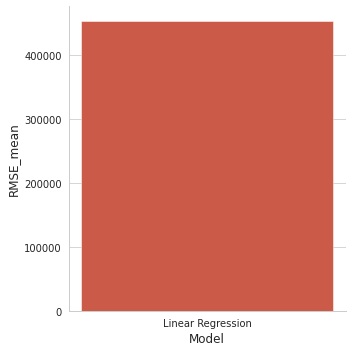

In [0]:
sns.factorplot(x= 'Model', y= 'RMSE_mean', data= modelDF, kind='bar', legend='True')

In conclusion, these are my final considerations on the model:

- the best feature to reliably predict the price of a Melbourne house is Distance. After distance that there is a group of 5 features including: number of rooms, Longitude and Latitude, and Southern Metropolitan region. This last dummy attribute is the only one relevant out of the original group of 7 regions. Thus, it seems that the best features are primarily related to the house location, and then to its size (there is also Building size to consider). This is why I chose that title!
- The type of the house seems less important than these two categories, as houseAge and Type_h are respectively 10th and 11th in this ranking. Category Type_t (or townhouse) is the less relevant feature in this cluster.
- Date features (i.e. Year and the four seasons) are not that important, but in any case the year when the house was sold is slightly more important than the season.